In [9]:
from arftools import *
import numpy as np
from numpy import linalg as LA
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import cm


def mse(datax,datay,w):
    """ retourne la moyenne de l'erreur aux moindres carres """
    n, d = datax.shape
    loss = np.dot((np.dot(datax,w.T)-datay),(np.dot(datax,w.T)-datay).T)
    return loss/n

def mse_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur au moindres carres """
    weights = w
    x,y = weights.shape
    n, d = datax.shape
    #import ipdb; ipdb.set_trace()
    grad = 2*np.dot(datax.T,(np.dot(datax,weights.T)-datay))
    avg_grad = grad.reshape(x,y)/n
    return avg_grad

def mser(datax,datay,w,alpha=1):
    n, d = datax.shape
    loss = np.dot((np.dot(datax,w.T)-datay),(np.dot(datax,w.T)-datay).T)
    return loss/n +alpha*LA.norm(w)

def mseLasso(datax,datay,w, alpha=1):
    n, d = datax.shape
    loss = np.dot((np.dot(datax,w.T)-datay),(np.dot(datax,w.T)-datay).T)
    return loss/n + alpha*LA.norm(w,1)

def hinge(datax,datay,w):
    """ retourn la moyenne de l'erreur hinge """
    n, d = datax.shape
    loss = np.maximum(np.zeros(n), -np.dot(datax,w.T)*datay)
    loss_avg = np.mean(loss)
    return loss_avg

def hinge_g(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    datax,datay=datax.reshape(len(datay),-1),datay.reshape(-1,1)
    loss = np.maximum(np.zeros(len(datay)), -np.squeeze(np.dot(datax,w.T))*np.squeeze(datay))
    loss = loss.reshape(-1,1)
    grad = -np.sign(loss)*(datay*datax)
    
    return np.mean(grad, axis = 0)

def hinge_g_biais(datax,datay,w):
    """ retourne le gradient moyen de l'erreur hinge """
    datax,datay=datax.reshape(len(datay),-1),datay.reshape(-1,1)
    datax_b = np.hstack((datax,np.ones((len(datay),1))))
    loss = np.maximum(np.zeros(len(datay)), -np.squeeze(np.dot(datax_b,w.T))*np.squeeze(datay))
    loss = loss.reshape(-1,1)
    grad = -np.sign(loss)*(datay*datax_b)
    #import ipdb; ipdb.set_trace()
    return np.mean(grad, axis = 0)

class Lineaire(object):
    def __init__(self,loss=hinge,loss_g=hinge_g,max_iter=1000,eps=0.01,biais = False):
        """ :loss: fonction de cout
            :loss_g: gradient de la fonction de cout
            :max_iter: nombre d'iterations
            :eps: pas de gradient
        """
        self.max_iter, self.eps = max_iter,eps
        self.loss, self.loss_g = loss, loss_g
        self.biais = biais

    def fit(self,datax,datay,testx=None,testy=None):
        """ :datax: donnees de train
            :datay: label de train
            :testx: donnees de test
            :testy: label de test
        """
        # on transforme datay en vecteur colonne
        datay = datay.reshape(-1,1)
        N = len(datay)
        datax = datax.reshape(N,-1)
        D = datax.shape[1]
        
        #dim w = D+1 pour l'inclusion du biais
        if self.biais == True:
            self.w = np.random.random((1,D+1))
        else:
            self.w = np.random.random((1,D))
        
        ######################
        #descente de gradient#
        ######################
          
        for i in range(self.max_iter):
            avg_grad = self.loss_g(datax, datay, self.w)
            self.w-=self.eps*avg_grad
            #import ipdb; ipdb.set_trace()
            #Visualisation de l'apprentissage dans l'espace des poids
            #plt.scatter(self.w[0][0],self.w[0][1], c="blue")
            
                        
                
    def model(self,x):
        #Perceptron
        if self.loss == hinge:
            return 1 if (np.dot(self.w, np.concatenate((x,[1]))) >= 0) else -1
        
        #Regression
        elif self.loss == mse:
            return 1 if np.dot(self.w, x) >= 0 else -1
            
    def predict(self,datax):
        if len(datax.shape)==1:
            datax = datax.reshape(1,-1)
        pred = []
        for x in datax:
            pred.append(self.model(x))
        return np.array(pred)
            
            

    def score(self,datax,datay):
        acc = 0
        pred = self.predict(datax)
        for p, label in zip(pred,datay):
            if p == label:
                acc+=1
        return acc/len(datay)
    
    def getWeights(self):
        return self.w
            



def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")



def plot_error(datax,datay,f,step=10):
    grid,x1list,x2list=make_grid(xmin=-4,xmax=4,ymin=-4,ymax=4)
    plt.contourf(x1list,x2list,np.array([f(datax,datay,w) for w in grid]).reshape(x1list.shape),25)
    plt.colorbar()
    plt.show()

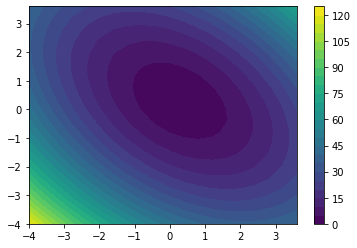

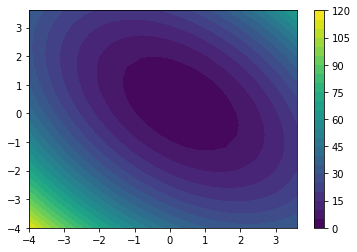

Erreur : train 0.909000, test 0.919000


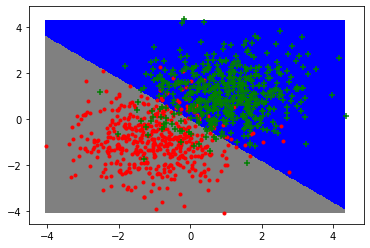

In [10]:
if __name__=="__main__":
    """ Tracer des isocourbes de l'erreur """
    plt.ion()
    trainx,trainy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
    testx,testy =  gen_arti(nbex=1000,data_type=0,epsilon=1)
    plt.figure()
    plot_error(trainx,trainy,mser)
    plt.figure()
    plot_error(trainx,trainy,mse)
    
    
    perceptron = Lineaire(mse,mse_g,max_iter=2000,eps=0.1,biais = False)
    perceptron.fit(trainx,trainy)
    
    print("Erreur : train %f, test %f"% (perceptron.score(trainx,trainy),perceptron.score(testx,testy)))
    plt.figure()
    plot_frontiere(trainx,perceptron.predict,200)
    plot_data(trainx,trainy)